In [1]:
#%cd C:/Users/Mathieu/Desktop/Projets/Benter
%cd /home/mathieu/Mindsay/mathieu/Benter-Project

[Errno 2] No such file or directory: '/home/mathieu/Mindsay/mathieu/Benter-Project'
/home/mathieu/Prose/Mathieu/Benter-Project/scripts


In [2]:
%matplotlib inline
import collections
import functools
import json

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from joblib import Memory

from utils import import_data
from utils import wagering_stategy
from utils import permutations
from utils import preprocess
from winning_horse_models.logistic_regression import LogisticRegressionModel
from constants import PMU_BETTINGS, SOURCE_PMU
from utils.wagering_stategy import compute_expected_return, compute_scenario, plot_scenario
import wagering_stategies
from wagering_stategies import factories as wagering_factories
from constants import CACHE_DIR
from winning_validation.r_squared import compute_mcfadden_r_squared
from winning_validation import errors
from training_procedures import sequential_training
from typing import List, Tuple
from winning_horse_models import AbstractWinningModel
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFpr, f_classif

from matplotlib import style
style.use('ggplot')

winning_model = LogisticRegressionModel.load_model()
SOURCE='PMU'

ModuleNotFoundError: No module named 'utils'

In [3]:
# https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2
#https://www.kaggle.com/allunia/m5-sales-uncertainty-prediction
# https://towardsdatascience.com/the-hitchhikers-guide-to-feature-extraction-b4c157e96631

In [3]:
# Adapt SGD logistic regression to find best subset of features
# 3min to train on given features on 1 epochs

sequential_sgd_regression, training_history =sequential_training.train_on_each_horse_with_epochs(source=SOURCE, 
                                                                                                 winning_model=LogisticRegressionModel(), 
                                                                                                 n_epochs=1, verbose=False)

In [4]:
exact_top_1 = errors.compute_validation_error(source="PMU", 
                                                          k=1,
                                                          winning_model=sequential_sgd_regression, 
                                                          validation_method=errors.exact_top_k)
errors.compute_overall_average(exact_top_1)

(0.24301336573511542, 0.09218307006885379, 0.27112191170514377)

In [5]:
r_squared=compute_mcfadden_r_squared(source='PMU', winning_model=sequential_sgd_regression, verbose=False)
print(r_squared['combined_model_r_squared'], r_squared['combined_odds_r_squared'])

0.10703483468339403 0.19171143217213338


In [7]:
# Before log prizes
#(0.2401782098015391, 0.09218307006885379, 0.27112191170514377)
# 0.10054970429244015 0.19171143217213338

# After log prizes
#(0.24094775212636696, 0.09218307006885379, 0.27112191170514377)
#0.10041886529877808 0.19171143217213338


In [3]:
race_horse_df = import_data.load_featured_data(source=SOURCE_PMU)

/home/mathieu/.pyenv/versions/3.7.4/envs/venv_benter/lib/python3.7/site-packages/ipython-7.15.0-py3.7.egg/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (35,46,47,61,62,63,64,87) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
x = preprocess.preprocess(race_horse_df=race_horse_df, source='PMU')
y = race_horse_df["horse_place"] == 1

/home/mathieu/.pyenv/versions/3.7.4/envs/venv_benter/lib/python3.7/site-packages/pandas-1.0.4-py3.7-linux-x86_64.egg/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/mathieu/Mindsay/mathieu/Benter-Project/utils/preprocess.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ) / standard_scaler_parameters[numerical_feature]["std"]
/home/mathieu/.pyenv/versions/3.7.4/envs/venv_benter/lib/python3.7/site-packages/pandas-1.0.4-py3.7-linux-x86_64.egg/pandas/core

In [9]:
# https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

In [10]:
constant_columns=(x == x.iloc[0]).all()
constant_columns[constant_columns]

Series([], dtype: bool)

In [13]:
feature_columns=preprocess.get_preprocessed_columns(source='PMU')

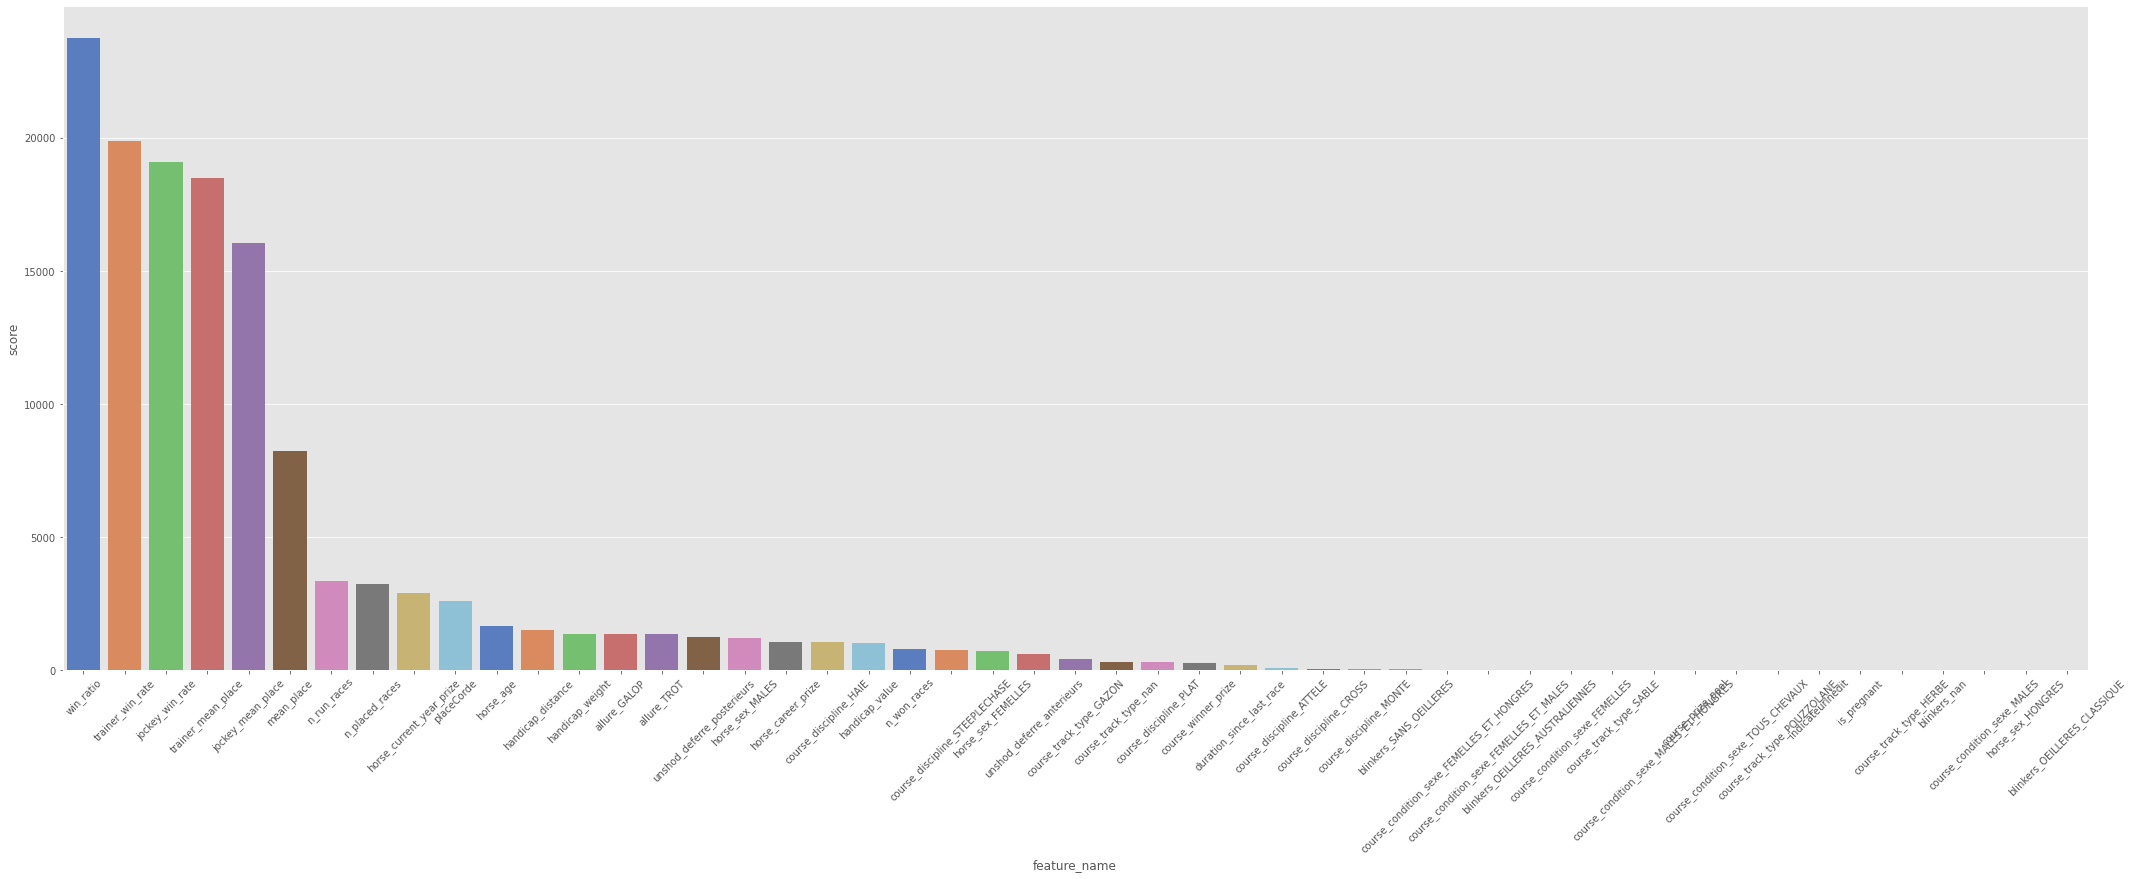

In [14]:
selector = SelectKBest(score_func=f_classif, k=10)
_=selector.fit_transform(x, y)
scores=np.nan_to_num(selector.scores_ , nan=-np.inf)
score_df = pd.DataFrame({'feature_name': feature_columns, 'score': scores})

data=score_df.sort_values(by='score',ascending=False)

g = sns.catplot(x="feature_name", y="score", data=data,
                kind="bar", palette="muted", height=10, aspect=3)
g.set_xticklabels(rotation=45);

In [ ]:
# Conclusion: 6 features are important right now (win_ratio, trainer_win_rate, jockey_win_rate, trainer_mean_place, jockey_mean_place, mean_place)
# All from the past

In [15]:

#selector = SelectKBest(score_func=f_classif, k=10)

#_=selector.fit_transform(x, y)

for k in [1,2,5,10, 15, 20, 30]:
    print('Select k=',k)

    selected_indexes=np.nan_to_num(selector.scores_ , nan=-np.inf).argsort()[-k:][::-1]

    print(np.array(feature_columns)[selected_indexes].tolist())

    # train on selected features
    feature_limited_model, training_history = sequential_training.train_on_each_horse_with_epochs(source='PMU', 
                                                                                  winning_model=LogisticRegressionModel(selected_features=selected_indexes),
                                                                                  n_epochs=1,
                                                                                  verbose=False
                                                                             )

    exact_top_1 = errors.compute_validation_error(source="PMU", 
                                                              k=1,
                                                              winning_model=feature_limited_model, 
                                                              validation_method=errors.exact_top_k)
    print("average accuracy ", errors.compute_overall_average(exact_top_1))

    r_squared=compute_mcfadden_r_squared(source='PMU', winning_model=feature_limited_model, verbose=False)
    print( "r²", r_squared['combined_model_r_squared'], r_squared['combined_odds_r_squared'])
    print()

Select k= 1
['win_ratio']
average accuracy  (0.28647225597407855, 0.09218307006885379, 0.27112191170514377)
r² 0.03603628852994489 0.19171143217213338

Select k= 2
['win_ratio', 'trainer_win_rate']
average accuracy  (0.21121911705143784, 0.09218307006885379, 0.27112191170514377)
r² 0.05573947452627537 0.19171143217213338

Select k= 5
['win_ratio', 'trainer_win_rate', 'jockey_win_rate', 'trainer_mean_place', 'jockey_mean_place']
average accuracy  (0.2246253543944917, 0.09218307006885379, 0.27112191170514377)
r² 0.08147492817877011 0.19171143217213338

Select k= 10
['win_ratio', 'trainer_win_rate', 'jockey_win_rate', 'trainer_mean_place', 'jockey_mean_place', 'mean_place', 'n_run_races', 'n_placed_races', 'horse_current_year_prize', 'placeCorde']
average accuracy  (0.22879708383961117, 0.09218307006885379, 0.27112191170514377)
r² 0.08540152638528431 0.19171143217213338

Select k= 15
['win_ratio', 'trainer_win_rate', 'jockey_win_rate', 'trainer_mean_place', 'jockey_mean_place', 'mean_plac

In [16]:
# Conclusion: Adding more features, does not improve model Accuracy but R² along th enumber of features
# Most of r² improvement comes with the first 5 features (and some features between the 16th and 20th)

In [ ]:
# Testing new features

In [6]:
selected_features = ['win_ratio', 'trainer_win_rate', 'jockey_win_rate', 'trainer_mean_place', 'jockey_mean_place', 'mean_place']
all_features = preprocess.get_preprocessed_columns(source='PMU')

In [7]:
selected_indexes = sorted([all_features.index(feat) for feat in selected_features])

In [8]:
selected_indexes

[15, 16, 17, 18, 19, 20]

In [9]:
# train on selected features
feature_limited_model, training_history = sequential_training.train_on_each_horse_with_epochs(source='PMU', 
                                                                              winning_model=LogisticRegressionModel(selected_features=selected_indexes),
                                                                              n_epochs=1,
                                                                              verbose=False
                                                                         )

exact_top_1 = errors.compute_validation_error(source="PMU", 
                                                          k=1,
                                                          winning_model=feature_limited_model, 
                                                          validation_method=errors.exact_top_k)
print("average accuracy ", errors.compute_overall_average(exact_top_1))

r_squared=compute_mcfadden_r_squared(source='PMU', winning_model=feature_limited_model, verbose=False)
print( "r²", r_squared['combined_model_r_squared'], r_squared['combined_odds_r_squared'])
print()

average accuracy  (0.22494937221547184, 0.09218307006885379, 0.27112191170514377)
r² 0.08337529678080557 0.19171143217213338



In [6]:
def inside_corde_horse(race_df):
    
    if pd.isnull(race_df['course_corde']).all() or race_df['course_corde'].iloc[0]=="CORDE_GAUCHE":
        return pd.DataFrame({'insidest_corde':(race_df['horse_number']==race_df['horse_number'].min()).values})

    else:
        return pd.DataFrame({'insidest_corde':(race_df['horse_number']==race_df['horse_number'].max()).values})

In [7]:
selected_indexes=[15, 16, 17, 18, 19, 20]

In [8]:
%%time
# train on selected features
feature_limited_model, training_history = sequential_training.train_on_each_horse_with_epochs(source='PMU', 
                                                                              winning_model=LogisticRegressionModel(n_features=len(selected_indexes)+1),
                                                                                              selected_features_index=selected_indexes,
                                                                              n_epochs=1,
                                                                            extra_features_func=inside_corde_horse,
                                                                              verbose=False
                                                                         )

CPU times: user 4min 38s, sys: 2.52 s, total: 4min 41s
Wall time: 4min 38s


In [9]:
exact_top_1 = errors.compute_validation_error(source="PMU", 
                                                          k=1,
                                                          winning_model=feature_limited_model, 
                                              selected_features_index=selected_indexes,
                                              extra_features_func=inside_corde_horse,
                                                          validation_method=errors.exact_top_k)
print("average accuracy ", errors.compute_overall_average(exact_top_1))

r_squared=compute_mcfadden_r_squared(source='PMU', winning_model=feature_limited_model, verbose=False)
print( "r²", r_squared['combined_model_r_squared'], r_squared['combined_odds_r_squared'])
print()

average accuracy  (0.2250303766707169, 0.09218307006885379, 0.27112191170514377)


TypeError: 'NoneType' object is not iterable